In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib
import numpy as np
#sns.set()

import glob

pd.options.mode.chained_assignment = None 

In [3]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:90% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [4]:
baseFolderLoc = "/d/grid13/ln16/topologyAnalysis/logFile/"
folderLocation = baseFolderLoc+"data/"
files = glob.glob(folderLocation+"*txt")
files

['/d/grid13/ln16/topologyAnalysis/logFile/data/composition_0.txt']

In [5]:
listDFs = []
for file in files[0:1]:
    listDFs.append(pd.read_csv(file, delimiter=" ",names=["topology","composition","eventNum","beamParticleID", "spectroscopicID","chiSq","unusedEnergy"
                                                         ,"nUnusedShowers"]))
data = pd.concat(listDFs, axis=0, ignore_index=True)

------
There is symmetry between the photons in a given π or η. We apply this symmetry making the uniqueComposition column

In [6]:
uniqueComposition = []

for string1 in data.composition:
    splittedStrings = string1.split("_")
    pair1 = set([splittedStrings[0],splittedStrings[1]])
    pair2 = set([splittedStrings[2],splittedStrings[3]])
    uniqueComposition.append("_".join([ele for ele in pair1])+"__"+"_".join([ele for ele in pair2]))

data['uniqueComposition'] = uniqueComposition

----
We can apply our cuts here. Since we will need to reuse these bools later when we narrow ourselves into some topologies we will save them into the dataframe for now

In [7]:
cutNone = data.unusedEnergy > -999
cutUE = data.unusedEnergy < 0.01
cutChi = data.chiSq < 13.277
cutUEChiSq = cutUE & cutChi
cutBools = [cutNone,cutUE,cutChi,cutUEChiSq]
cutNames = ["None","UE","ChiSq","UE*ChiSq"]
for iCut, cut in enumerate(cutBools):
    dataCut = data[cut]
        
    # calculate event weights that is dependent on the cuts we apply
    eventToWeights = dataCut.eventNum.value_counts()
    eventToWeights = dict(zip(eventToWeights.index,1.0/eventToWeights.values))
    data["w"+cutNames[iCut]] = dataCut.eventNum.map(eventToWeights)
data = data.fillna(0)

-----
What is the purity of the real 7__17 composition?

In [8]:
for iCut, cut in enumerate(cutBools):
    cutToApply = "w"+cutNames[iCut]
    purity = data[data.uniqueComposition=="(7)__(17)"][cutToApply].sum()/data[cutToApply].sum()
    purity = str(int(100*purity))
    print("Purity with cut="+cutToApply+": "+purity)

Purity with cut=wNone: 40
Purity with cut=wUE: 79
Purity with cut=wChiSq: 85
Purity with cut=wUE*ChiSq: 89


In [9]:
inputData = data[data.topology=="4#gammap[#pi^{0},#eta]"]
correctEvents = len(inputData[inputData.uniqueComposition=="(7)__(17)"].eventNum.unique())
totEvents = len(inputData.eventNum.unique())
print("Percentage of events that uses the true combo atleast once: "+str(correctEvents/totEvents))

Percentage of events that uses the true combo atleast once: 0.8767925671581499


In [220]:
inputDataChiSqCut = inputData[inputData["wUE*ChiSq"]>0]
correctEvents = len(inputDataChiSqCut[inputDataChiSqCut.uniqueComposition=="(7)__(17)"].eventNum.unique())
totEvents = len(inputDataChiSqCut.eventNum.unique())
print("(ChiqCut)Percentage of events that uses the true combo atleast once: "+str(correctEvents/totEvents))

(ChiqCut)Percentage of events that uses the true combo atleast once: 0.9389312977099237


------
How many unique compositions are there in a given event?

In [179]:
uniqueCompsPerEvent = inputData.groupby("eventNum")["uniqueComposition"].value_counts()#.droplevel(level=1)
uniqueCompsPerEvent

eventNum  uniqueComposition 
1         (7)_(0)__(17)         3
4         (7)__(17)             2
5         (7)__(17)             6
7         (7)__(17)             7
8         (7)__(17)             4
                               ..
9996      (7)__(17)             3
9997      (7)__(17)             3
9998      (7)_(17)__(7)_(17)    3
          (7)__(17)             3
9999      (7)__(17)             6
Name: uniqueComposition, Length: 5774, dtype: int64

Text(0.5, 0, 'Unique compositions per event')

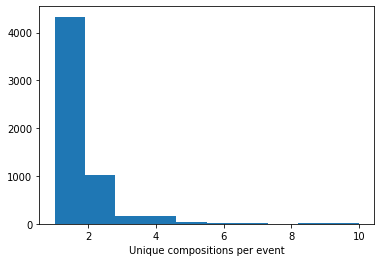

In [181]:
numDiffCompsPerEvent = []
for iEvent in uniqueCompsPerEvent.droplevel(level=1).index:
    numDiffCompsPerEvent.append(len(uniqueCompsPerEvent[iEvent]))
numDiffCompsPerEvent=np.array(numDiffCompsPerEvent)
plt.hist(numDiffCompsPerEvent)
plt.xlabel("Unique compositions per event")

Text(0.5, 0, 'Composition of events with a single unique composition')

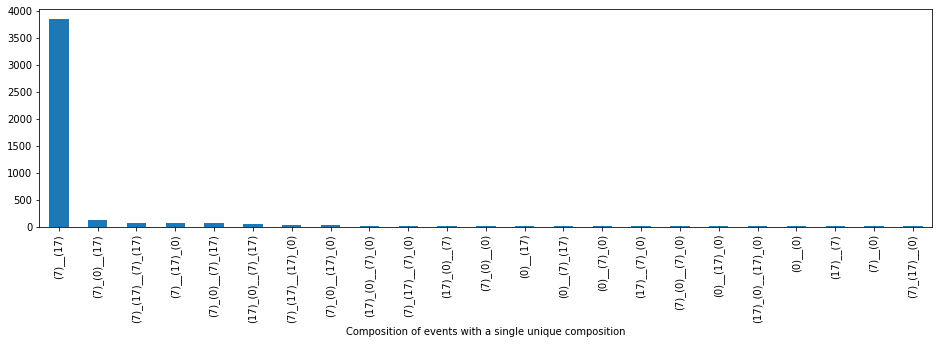

In [182]:
fig,ax = plt.subplots(figsize=(16,4))
uniqueCompsPerEvent.iloc[numDiffCompsPerEvent==1].droplevel(level=0).index.value_counts().plot(kind="bar")
ax.set_xlabel("Composition of events with a single unique composition")

In [10]:
keys = inputData.uniqueComposition.value_counts().index
values = np.arange(len(inputData.uniqueComposition.value_counts().index))
compositionMap = dict(zip(keys,values))
compositionsWithGT100Combos = inputData.uniqueComposition.value_counts()[inputData.uniqueComposition.value_counts()>100].index
compositionsWithGT100Combos = compositionsWithGT100Combos.drop('(7)__(17)')

In [99]:
pairCompData = np.zeros((len(compositionMap),len(compositionMap)))
eventsWith2Comps = uniqueCompsPerEvent.iloc[numDiffCompsPerEvent==2]
for iEvent in eventsWith2Comps.droplevel(level=1).index:
    ix, iy = eventsWith2Comps[iEvent].index.map(compositionMap)
    if ix > iy:
        pairCompData[ix,iy] += 1 
    else:
        pairCompData[iy,ix] += 1
pairCompData = pd.DataFrame(pairCompData,index=compositionMap.keys(),columns=compositionMap.keys())

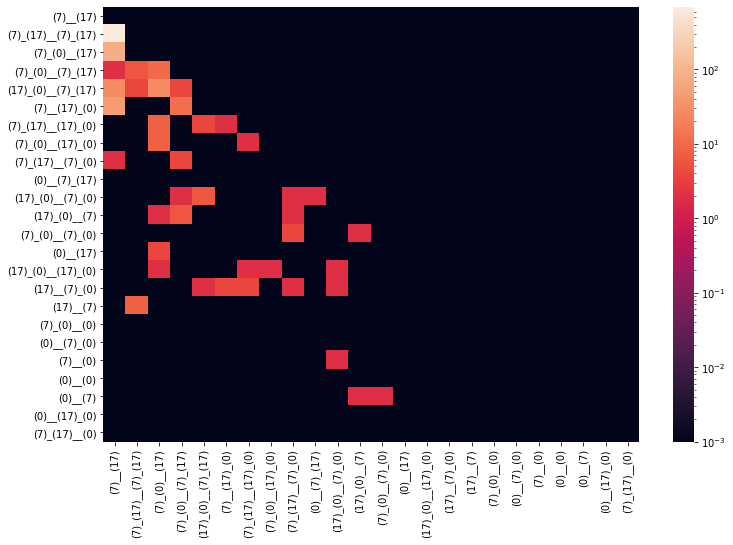

In [147]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(pairCompData+0.001,norm=LogNorm(vmin=0.01, vmax=pairCompData.max().max()))

In [23]:
numCombosFromSwap = inputData.uniqueComposition.value_counts()["(17)_(7)__(17)_(7)"]
numFakeCombos = inputData.uniqueComposition.value_counts()[~inputData.uniqueComposition.value_counts().index.isin(["(7)__(17)","(17)_(7)__(17)_(7)"])].sum()
numTotalCombos = len(inputData)
print("Num combos made from swaping a photon from the π to the η: {0}".format(numCombosFromSwap))
print("Num combos that are made with a fake photon: {0}".format(numFakeCombos))
inputData.uniqueComposition.value_counts()

Num combos made from swaping a photon from the π to the η: 3092
Num combos that are made with a fake photon: 4418


(7)__(17)             22567
(17)_(7)__(17)_(7)     3092
(0)_(7)__(17)          1264
(0)_(7)__(17)_(7)       675
(0)_(17)__(17)_(7)      589
(7)__(0)_(17)           552
(17)_(7)__(0)_(17)      311
(0)_(7)__(0)_(17)       204
(17)_(7)__(0)_(7)       166
(0)__(17)_(7)           160
(0)_(17)__(0)_(7)       125
(0)_(17)__(7)            82
(0)_(7)__(0)_(7)         47
(0)__(17)                42
(0)_(17)__(0)_(17)       38
(17)__(0)_(7)            37
(17)__(7)                30
(0)_(7)__(0)             22
(0)__(0)_(7)             18
(7)__(0)                 15
(0)__(0)                 15
(0)__(7)                 13
(0)__(0)_(17)            12
(17)_(7)__(0)             1
Name: uniqueComposition, dtype: int64

Text(0.5, 0, 'Number of unused showers')

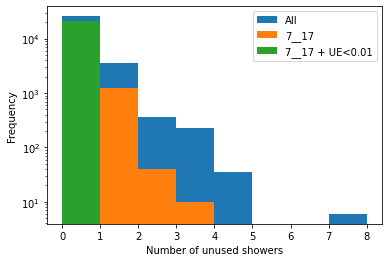

In [24]:
fig,ax1 = plt.subplots()
# getting bin locations by first stacking both histograms, make the histogram, and use the bin edges
tempStack = np.hstack((inputData.nUnusedShowers,inputData[inputData.uniqueComposition=="(7)__(17)"].nUnusedShowers))
binLocs = np.histogram(tempStack,bins=tempStack.max())[1]
inputData.nUnusedShowers.plot(kind="hist",logy=True,ax=ax1,bins=binLocs,label="All")
inputData[inputData.uniqueComposition=="(7)__(17)"].nUnusedShowers.plot(kind="hist",logy=True,ax=ax1,bins=binLocs,label="7__17")
inputData[(inputData.uniqueComposition=="(7)__(17)") & (inputData.unusedEnergy<0.01)].nUnusedShowers.plot(
    kind="hist",logy=True,ax=ax1,bins=binLocs,label="7__17 + UE<0.01")
plt.legend()
ax1.set_xlabel("Number of unused showers")

Text(0.5, 0, 'Unused Energy')

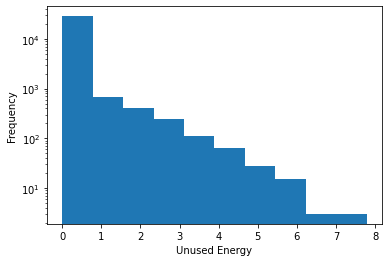

In [25]:
fig,ax1 = plt.subplots()
inputData.unusedEnergy.plot(kind="hist",logy=True)
ax1.set_xlabel("Unused Energy")



value counts of number of unused showers with cut on UE < 0.01
0    25911
Name: nUnusedShowers, dtype: int64


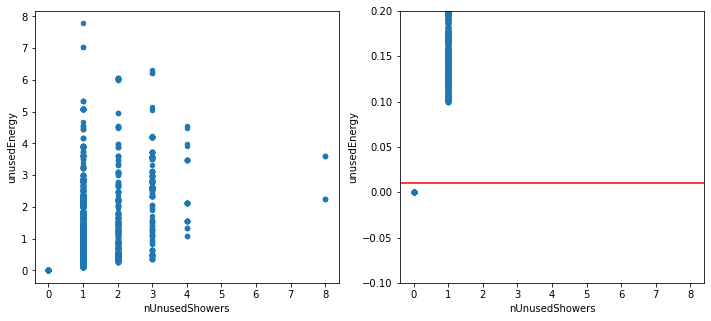

In [26]:
fig,ax1 = plt.subplots(1,2,figsize=(12,5))
inputData.plot(x="nUnusedShowers",y="unusedEnergy",kind="scatter",ax=ax1[0])
ax1[1].set_ylim(-0.1,0.2)
ax1[1].axhline(0.01,c="red")
inputData.plot(x="nUnusedShowers",y="unusedEnergy",kind="scatter",ax=ax1[1])
print("\n")
print("value counts of number of unused showers with cut on UE < 0.01")
print(inputData[inputData.unusedEnergy < 0.01].nUnusedShowers.value_counts())

Text(0.5, 0, '# unique spectroscopic combos per event')

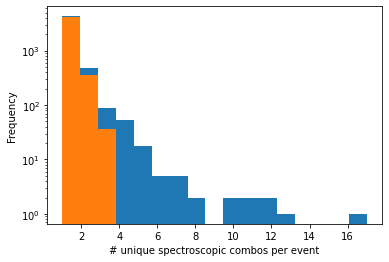

In [29]:
fig,ax = plt.subplots()
nUniqueSpectIDsPerEvent = inputData.groupby("eventNum")["spectroscopicID"].nunique()

binLocs = np.histogram(nUniqueSpectIDsPerEvent,bins=nUniqueSpectIDsPerEvent.max())[1]
nUniqueSpectIDsPerEvent.plot(kind="hist",bins=binLocs,logy=True,ax=ax)
ax.set_xlabel("# unique spectroscopic combos per event")
inputData = inputData[inputData.unusedEnergy<0.01]
nUniqueSpectIDsPerEvent = inputData.groupby("eventNum")["spectroscopicID"].nunique()
nUniqueSpectIDsPerEvent.plot(kind="hist",bins=binLocs,logy=True,ax=ax)
ax.set_xlabel("# unique spectroscopic combos per event")

In [184]:
#topologies = data.topology.unique()
topologyPercentages = data.topology.value_counts()/len(data)
print(topologyPercentages)
topologies = topologyPercentages[topologyPercentages>0.05].index

8#gammap[4#pi^{0},#eta]                                              0.677060
4#gammap[#pi^{0},#eta]                                               0.275822
4#gamma#pi^{#plus}#pi^{#minus}p[2#pi^{0},#eta]                       0.025879
7#gammae^{#plus}e^{#minus}p[4#pi^{0},#eta]                           0.017387
3#gamma#pi^{#plus}#pi^{#minus}p[#pi^{0},#eta]                        0.002604
3#gammae^{#plus}e^{#minus}#pi^{#plus}#pi^{#minus}p[2#pi^{0},#eta]    0.000614
3#gammae^{#plus}e^{#minus}p[#pi^{0},#eta]                            0.000449
6#gamma2e^{#plus}2e^{#minus}p[4#pi^{0},#eta]                         0.000174
2#gammae^{#plus}e^{#minus}#pi^{#plus}#pi^{#minus}p[#pi^{0},#eta]     0.000009
Name: topology, dtype: float64


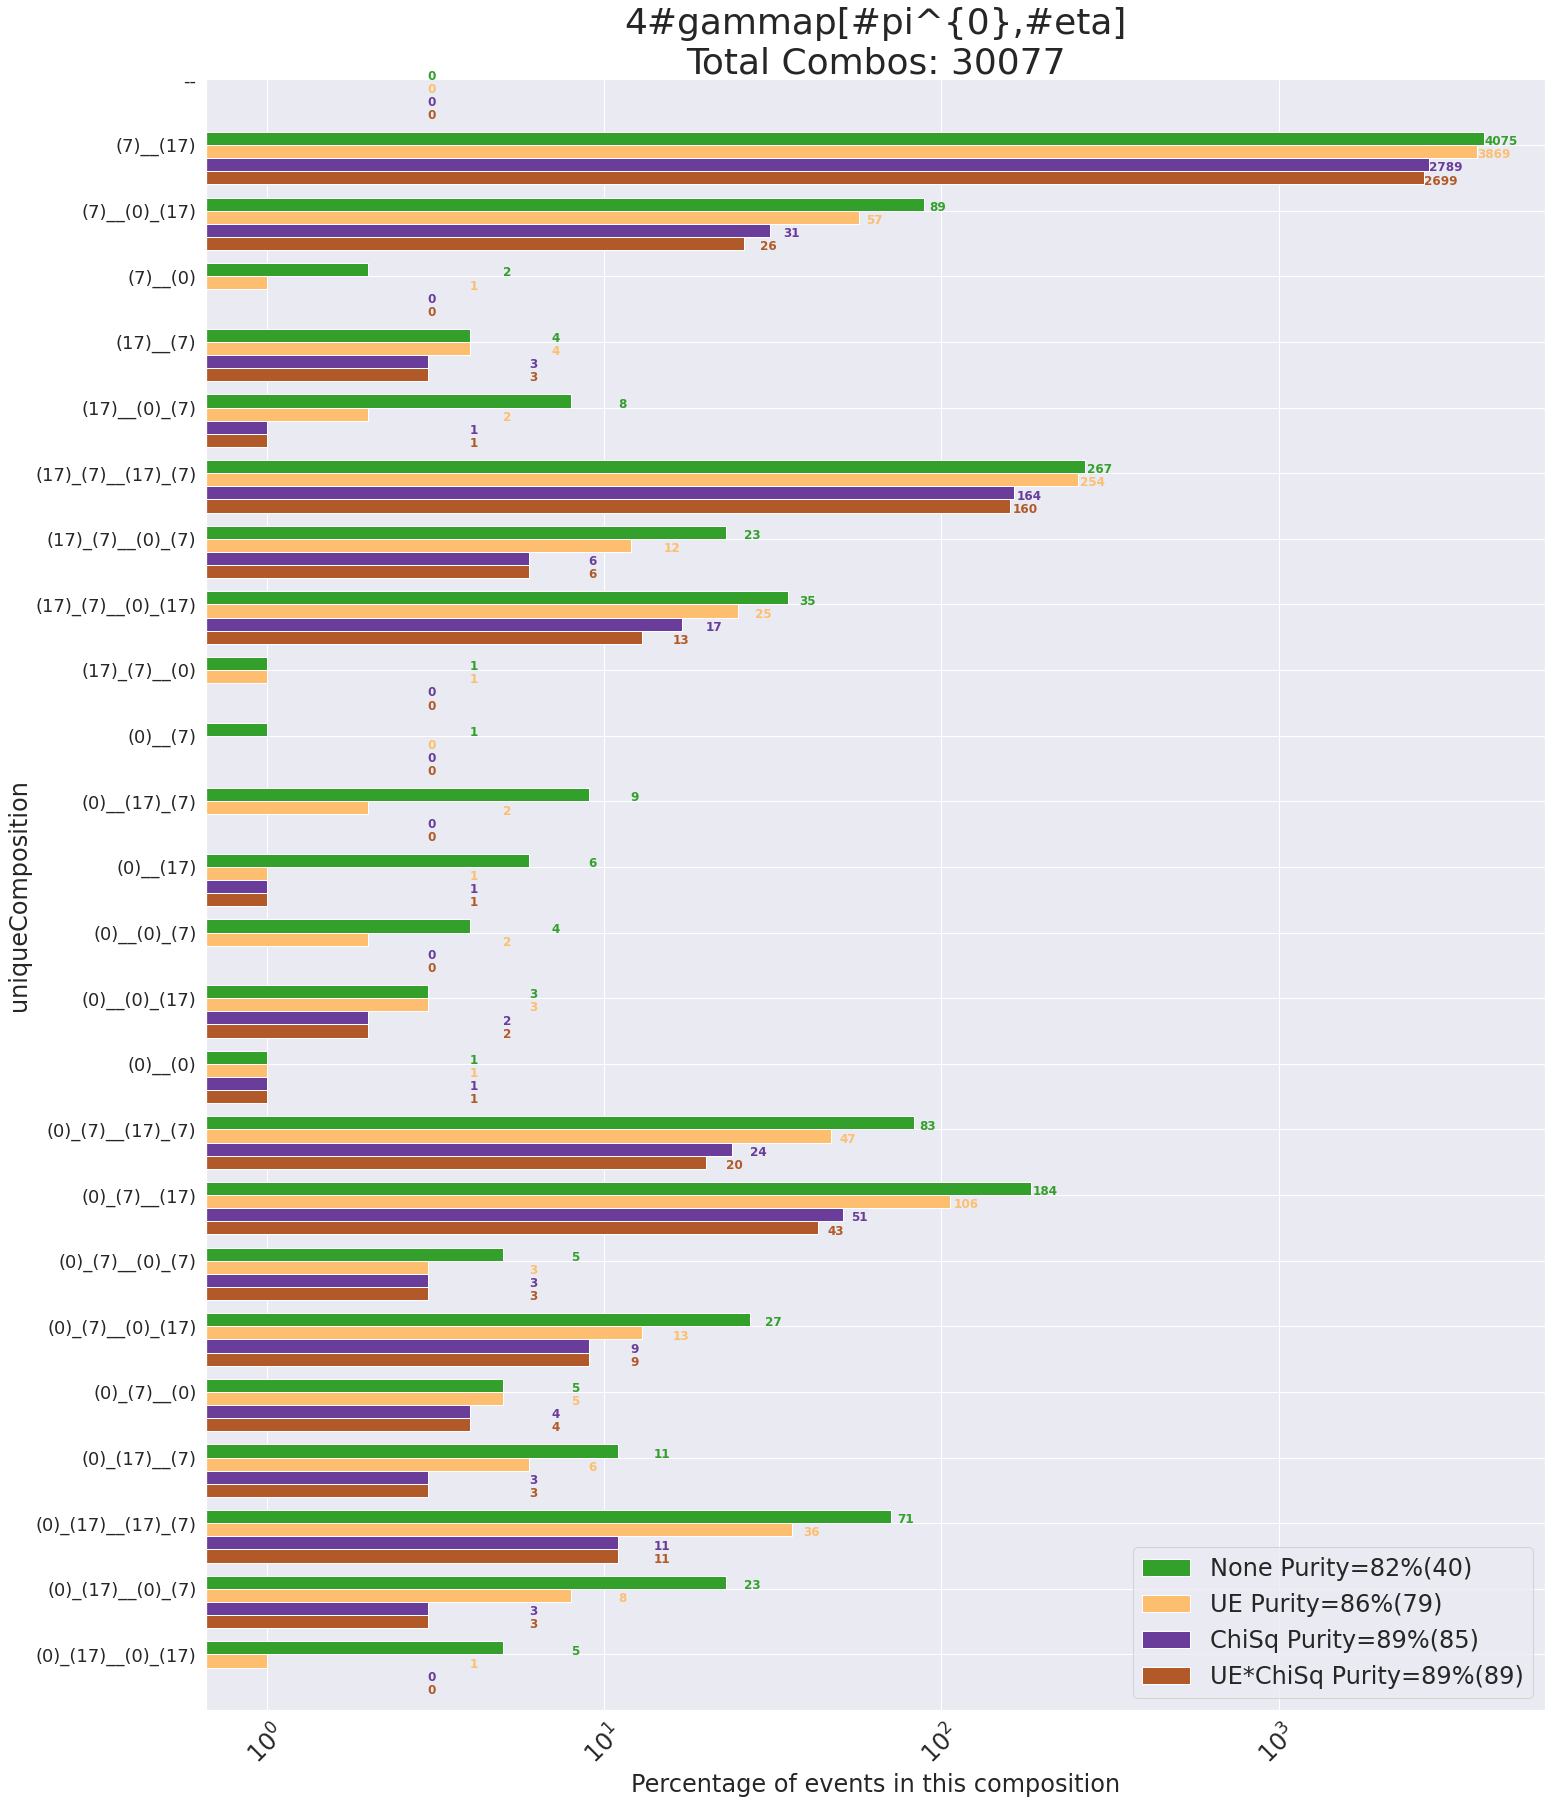

In [32]:
compositionMap = {}

for topology in topologies[1:2]:
    dataSingleTopology = data[(data.topology == topology)]
    
    # reduce the difference compositions that are equivalent due to symmetry of photons in the η or π
    uniqueComposition = []
    fullUniqueSet = dataSingleTopology['uniqueComposition'].unique()
    
    fig,ax = plt.subplots(figsize=(24,30))
    plt.xscale('log')
    plt.xticks(rotation=45,fontsize=24)
    plt.yticks(rotation=45,fontsize=18)
    ax.set_ylabel("Composition of pion__eta",fontsize=24)
    ax.set_xlabel("Percentage of events in this composition",fontsize=24)

    nEventsNoCuts = len(dataSingleTopology)
    ax.set_title(topology+"\nTotal Combos: "+str(nEventsNoCuts),fontsize=36)
    cmap = matplotlib.cm.get_cmap('Paired')
    sns.set(style="darkgrid")
    
    for iCut, cut in enumerate(cutBools):   
        #plotData = subsetData.value_counts()
        plotData = dataSingleTopology.groupby("uniqueComposition")["w"+cutNames[iCut]].sum().astype(int)
        for uniqueElement in fullUniqueSet:
            if uniqueElement not in plotData.index:
                plotData[uniqueElement] = 0
        plotData["--"]=0
        #print(plotData/len(subsetData))
        plotData = plotData.sort_index()
        currentColor = cmap((iCut+1)*1.0/(len(cutBools)))
        purityWithin4G = str(int(100*plotData["(7)__(17)"]/plotData.sum()))
        purityTotal = str(int(100*plotData["(7)__(17)"]/data["w"+cutNames[iCut]].sum()))
        label = cutNames[iCut]+" Purity="+purityWithin4G+"%("+purityTotal+")"
        plotData.plot(kind="barh",position=iCut,color=currentColor,width=0.2,label=label)
        for i, v in enumerate(plotData.values):
            text = ax.text(v + 3, i - .2*iCut, str(v), color=currentColor, fontweight='bold')
            #text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),path_effects.Normal()])
    ax.legend(fontsize=24)
    plt.savefig(baseFolderLoc+topology+".png",bbox_inches='tight',alpha=0.3)

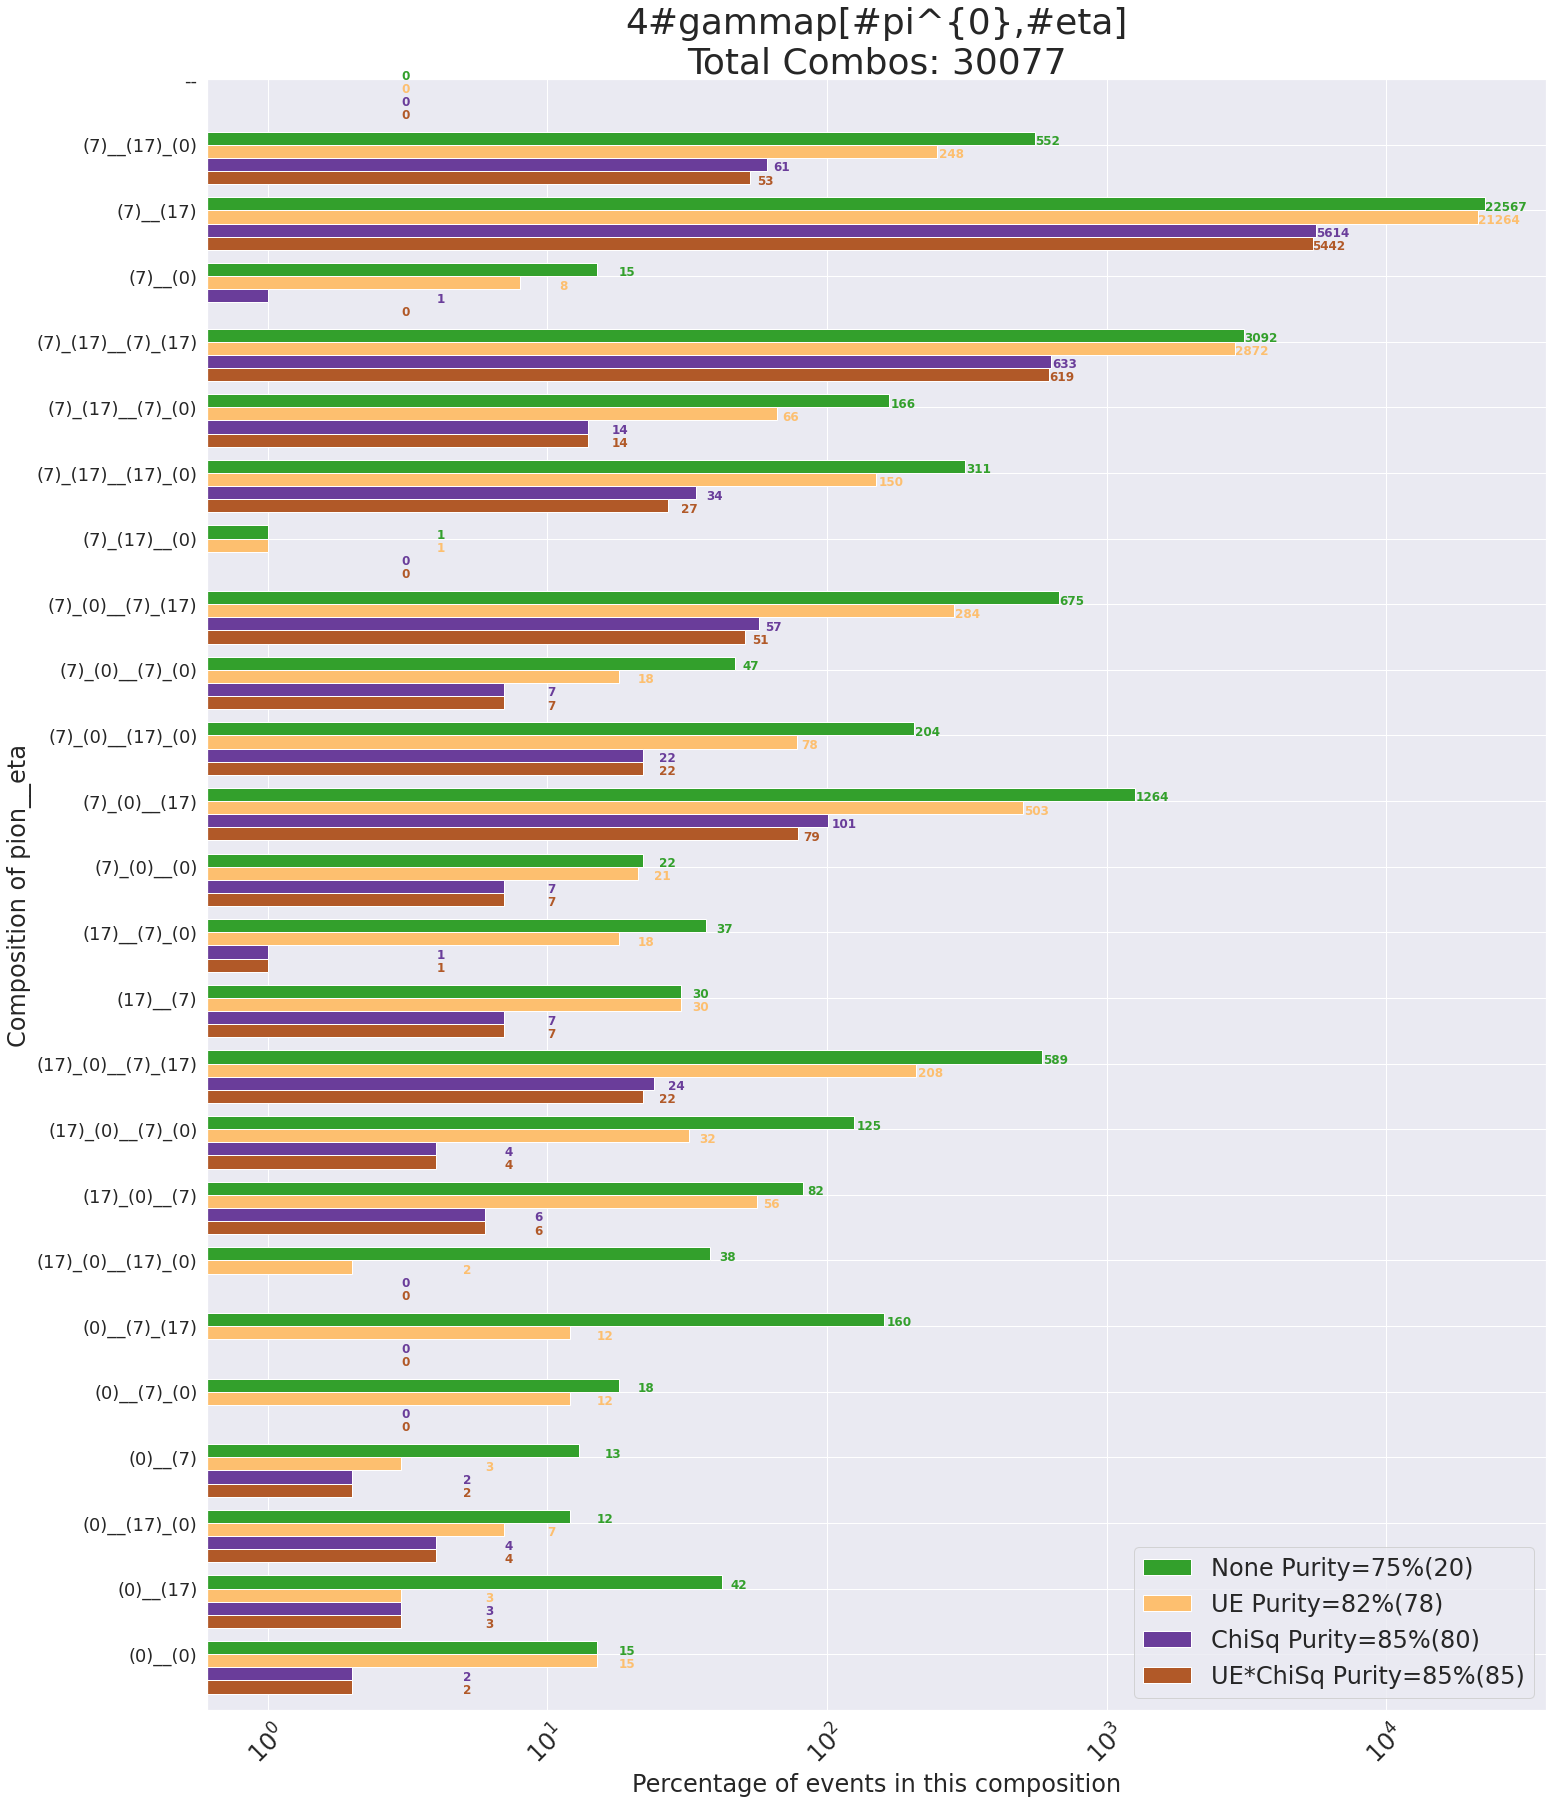

In [198]:
compositionMap = {}

for topology in topologies[1:2]:
    dataSingleTopology = data[(data.topology == topology)]
    
    # reduce the difference compositions that are equivalent due to symmetry of photons in the η or π
    uniqueComposition = []
    fullUniqueSet = dataSingleTopology['uniqueComposition'].unique()
    
    fig,ax = plt.subplots(figsize=(24,30))
    plt.xscale('log')
    plt.xticks(rotation=45,fontsize=24)
    plt.yticks(rotation=45,fontsize=18)
    ax.set_ylabel("Composition of pion__eta",fontsize=24)
    ax.set_xlabel("Percentage of events in this composition",fontsize=24)

    nEventsNoCuts = len(dataSingleTopology)
    ax.set_title(topology+"\nTotal Combos: "+str(nEventsNoCuts),fontsize=36)
    cmap = matplotlib.cm.get_cmap('Paired')
    sns.set(style="darkgrid")
    
    for iCut, cut in enumerate(cutBools):   
        plotData = dataSingleTopology[dataSingleTopology["w"+cutNames[iCut]]>0]["uniqueComposition"].value_counts()
        #plotData = dataSingleTopology.groupby("uniqueComposition")["w"+cutNames[iCut]].sum().astype(int)
        for uniqueElement in fullUniqueSet:
            if uniqueElement not in plotData.index:
                plotData[uniqueElement] = 0
        plotData["--"]=0
        #print(plotData/len(subsetData))
        plotData = plotData.sort_index()
        currentColor = cmap((iCut+1)*1.0/(len(cutBools)))
        purityWithin4G = str(int(100*plotData["(7)__(17)"]/plotData.sum()))
        purityTotal = str(int(100*plotData["(7)__(17)"]/len(data[data["w"+cutNames[iCut]]>0])))
        label = cutNames[iCut]+" Purity="+purityWithin4G+"%("+purityTotal+")"
        plotData.plot(kind="barh",position=iCut,color=currentColor,width=0.2,label=label)
        for i, v in enumerate(plotData.values):
            text = ax.text(v + 3, i - .2*iCut, str(v), color=currentColor, fontweight='bold')
            #text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),path_effects.Normal()])
    ax.legend(fontsize=24)
    plt.savefig(baseFolderLoc+topology+".png",bbox_inches='tight',alpha=0.3)